In [2]:
from collections import defaultdict

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from himalaya.scoring import correlation_score, correlation_score_split

from util import plot, subject
from util.path import Path
# from util.atlas import Atlas, get_brainmask
from constants import CONVS_STRANGERS, SUBS_STRANGERS, RUNS, RUN_TRIAL_SLICE, BLU, ORG

# import warnings
# warnings.filterwarnings("ignore")

In [3]:
%cd ..

/scratch/gpfs/zzada/fconv


In [4]:
# not all subjects have this..
SUBS_NAR = list(SUBS_STRANGERS)
SUBS_NAR.remove(11)
SUBS_NAR.remove(111)
SUBS_NAR.remove(12)

# banded regression performance

In [5]:
modelname = 'model-olmo-7b_layer-21'

features = ['task', 'spectral', 'articulatory', 'llm']

In [6]:
# load black results

respath = Path(
    root="encoding_black",
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

black_results = defaultdict(list)
for sub in tqdm(SUBS_NAR):
    respath.update(sub=f"{sub:03d}")
    with h5py.File(respath, "r") as f:
        black_results["cv_scores"].append(f["cv_scores"][:, :, :])

black_scores = np.stack(black_results["cv_scores"])
black_scores.shape

100%|██████████| 55/55 [00:01<00:00, 46.06it/s]


(55, 2, 4, 81924)

In [7]:
black_sub_scores = black_scores.mean(1)
black_feat_scores = black_sub_scores.mean(0)
black_feat_scores.shape

(4, 81924)

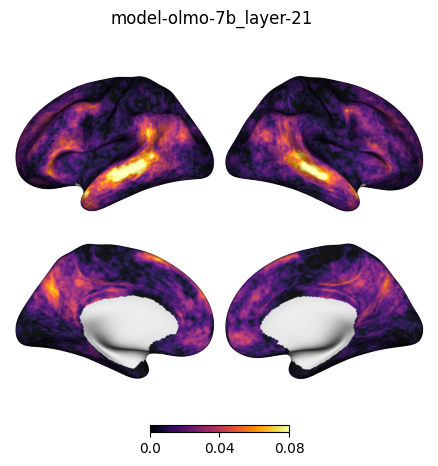

In [61]:
plot.surface_plot(black_feat_scores[3], vmin=0, cmap='inferno', title=modelname);

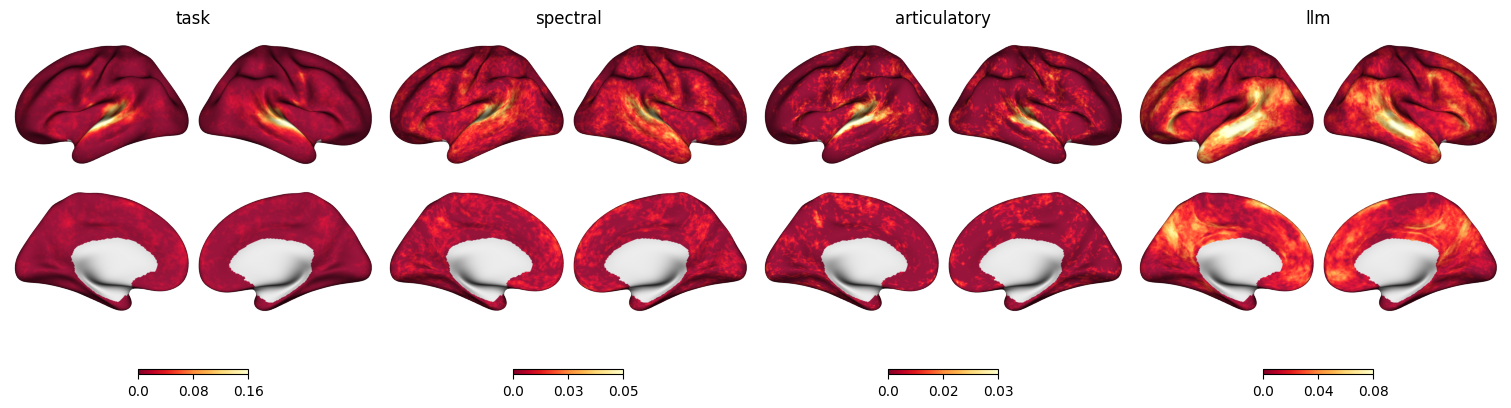

In [13]:
fig, axes = plt.subplots(1, len(features), figsize=(15, 6), layout='constrained')

for i, modelname, ax in zip(range(len(features)), features, axes):
    values = black_feat_scores[i]
    plot.surface_plot(values, fig=fig, ax=ax, vmin=0, cmap="YlOrRd_r", title=modelname)

fig.show()

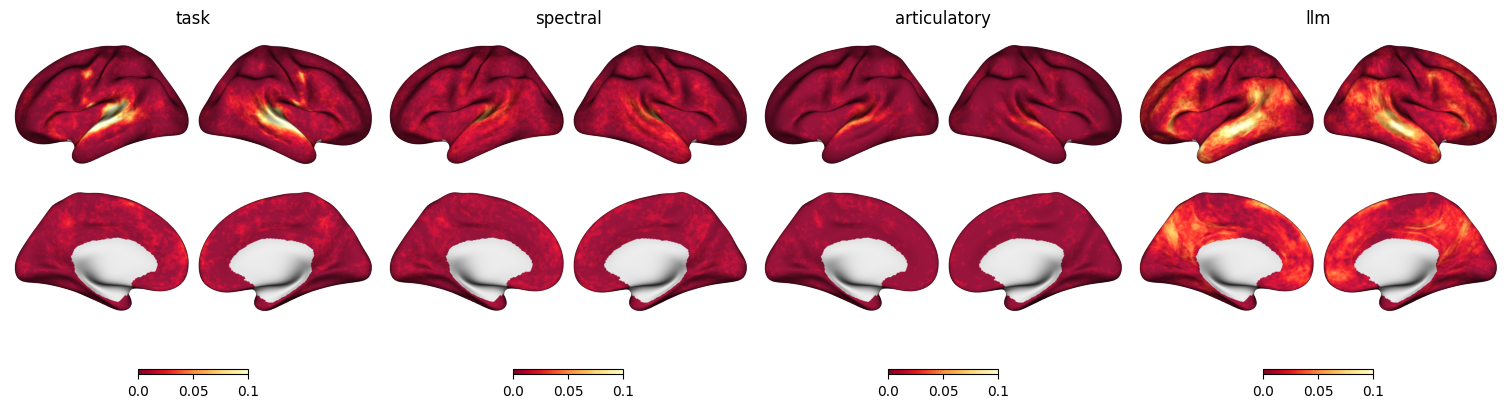

In [8]:
fig, axes = plt.subplots(1, len(features), figsize=(15, 6), layout='constrained')

for i, modelname, ax in zip(range(len(features)), features, axes):
    values = black_feat_scores[i]
    plot.surface_plot(values, fig=fig, ax=ax, vmin=0, vmax=0.1, cmap="YlOrRd_r", title=modelname)

fig.show()

# model comparison

In [5]:
# load black results

models = [
    'model-spectral_layer-23',
    'model-articulatory_layer-23',
    'model-syntactic_layer-23',
    'model-contextual_layer-0',
    'model-contextual_layer-21',
]

black_layers = {}
black_results = defaultdict(list)
for modelname in models:
    respath = Path(
        root="encoding_black",
        sub="000",
        datatype=modelname,
        ext=".hdf5",
    )

    for sub in SUBS_NAR:
        respath.update(sub=f"{sub:03d}")
        with h5py.File(respath, "r") as f:
            # select LLM and average over folds
            black_results[modelname].append(f["cv_scores"][:, -1, :].mean(0))

    black_layers[modelname] = np.stack(black_results[modelname])
black_layers[models[0]].shape

(55, 81924)

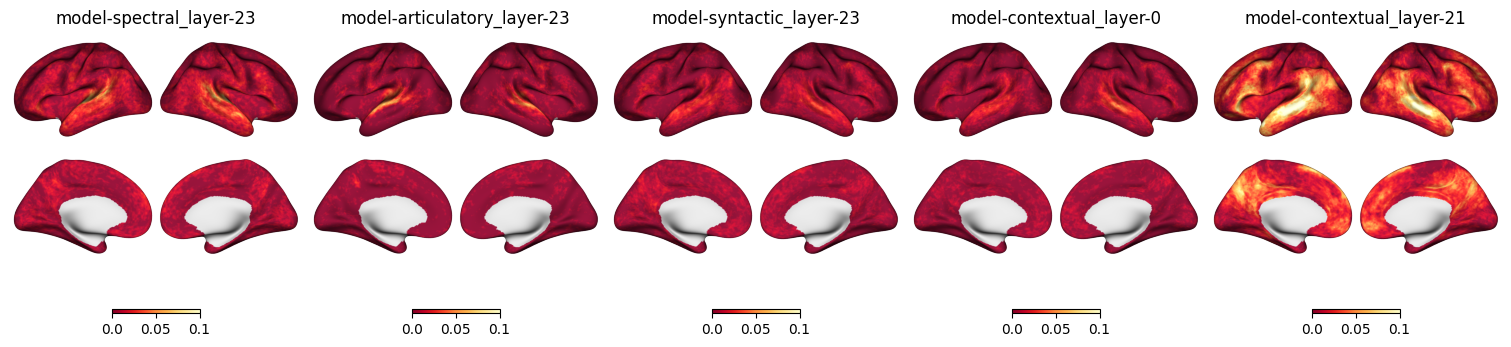

In [7]:
fig, axes = plt.subplots(1, len(models), figsize=(15, 6), layout='constrained')

for modelname, ax in zip(models, axes):
    values = black_layers[modelname].mean(0)
    sigmask = None
    plot.surface_plot(values, threshold=sigmask, fig=fig, ax=ax, vmin=0, vmax=0.1, cmap="YlOrRd_r", title=modelname)

fig.show()

# compare layers

In [6]:
layers = list(range(0, 33))

In [7]:
# load black results

black_layers = {}
black_results = defaultdict(list)
for layer in tqdm(layers):
    respath = Path(
        root="encoding_black",
        sub="000",
        datatype=f'model-olmo-7b_layer-{layer}',
        ext=".hdf5",
    )

    for sub in SUBS_NAR:
        respath.update(sub=f"{sub:03d}")
        with h5py.File(respath, "r") as f:
            # select LLM and average over folds
            black_results[layer].append(f["cv_scores"][:, -1, :].mean(0))

    black_layers[layer] = np.stack(black_results[layer])
black_layers[0].shape

100%|██████████| 33/33 [00:30<00:00,  1.09it/s]


(55, 81924)

In [8]:
means = [black_layers[i].mean() for i in layers]

21

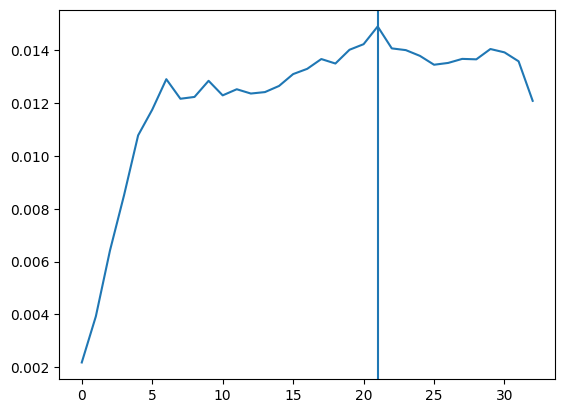

In [9]:
plt.plot(layers, means)
best_layer = layers[np.argmax(means)]
plt.axvline(best_layer)
best_layer

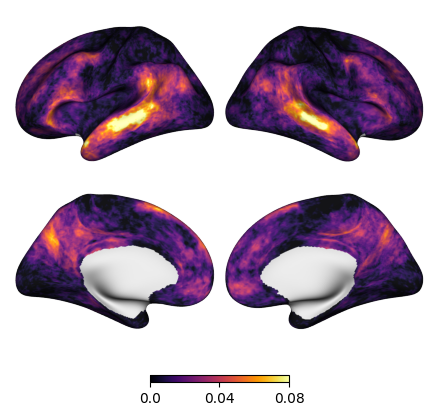

In [10]:
scores = black_layers[best_layer].mean(0)
plot.surface_plot(scores, vmin=0, cmap='inferno');

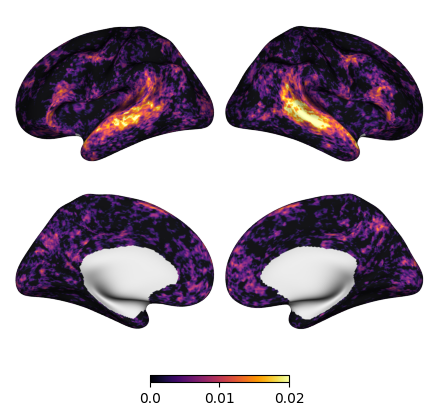

In [11]:
scores = black_layers[0].mean(0)
plot.surface_plot(scores, vmin=0, cmap='inferno');